In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import pickle

In [2]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=70)

from carpenter.display import display_merian_cutout_rgb
from carpenter.utils import SBP_star

In [5]:
channels = list('grizy') + ['N708', 'N540']

In [6]:
meas_cat = Table.read('./Catalogs/stars/tractor_stars_output_0_500.fits')
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'])

gaap_cat = Table.read('./Cutout/stars/stars_obj_cat.fits')
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    gaap_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'psf_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'cmodel_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_cModelFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

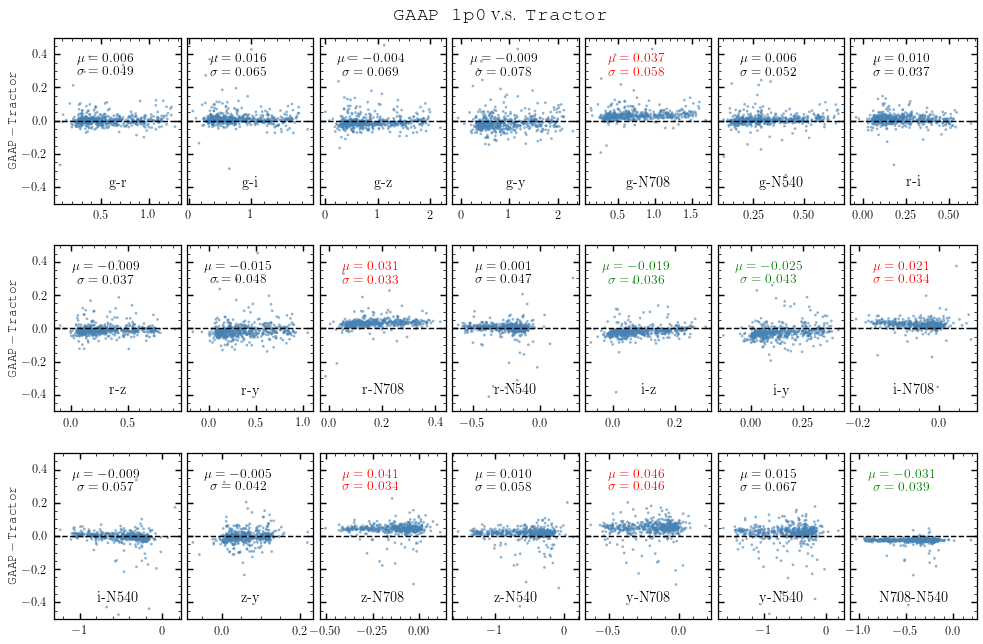

In [73]:
# all colors
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color1 - color2,
                s=8, color='steelblue', alpha=0.6,
                label=aper, edgecolors='none')
    _mean = np.nanmean(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.5, 0.5)
    plt.text((xlim[0] + xlim[1]) / 2, -0.4, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.35, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.27, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{Tractor}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle(r'$\texttt{GAAP\ 1p0}$ v.s. $\texttt{Tractor}$', y=0.92, fontsize=20)

plt.savefig('/tigress/jiaxuanl/public_html/Merian/stars/stars_gaap_tractor_comp.png', bbox_inches='tight', dpi=70)

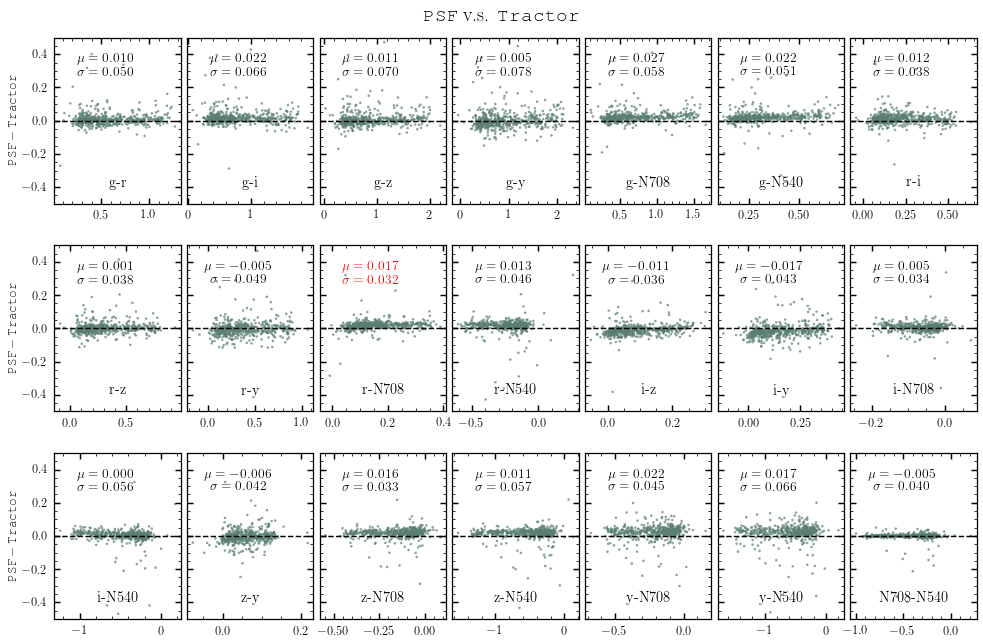

In [74]:
# all colors
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])

    color1 = gaap_cat['psf_mag'][:, filt1] - gaap_cat['psf_mag'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color1 - color2,
                s=7, color='#5A7F71', alpha=0.7,
                label=aper, edgecolors='none')
    _mean = np.nanmean(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.5, 0.5)
    plt.text((xlim[0] + xlim[1]) / 2, -0.4, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.35, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.27, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{PSF} - \texttt{Tractor}$')
     
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle(r'$\texttt{PSF}$ v.s. $\texttt{Tractor}$', y=0.92, fontsize=20)

plt.savefig('/tigress/jiaxuanl/public_html/Merian/stars/stars_psf_tractor_comp.png', bbox_inches='tight', dpi=70)

Text(0.5, 0.92, '$\\texttt{GAAP}$ v.s. $\\texttt{PSF}$')

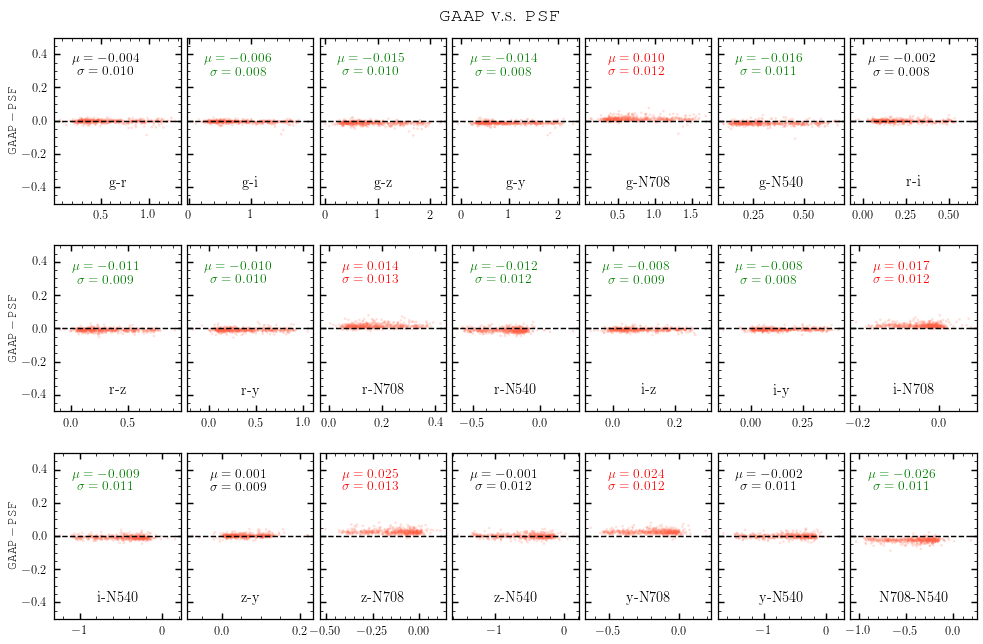

In [103]:
# all colors
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = gaap_cat['psf_mag'][:, filt1] - gaap_cat['psf_mag'][:, filt2]
    plt.scatter(color1, color1 - color2,
                s=7, color='tomato', alpha=0.2,
                label=aper, edgecolors='none')
    _mean = np.nanmean(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.5, 0.5)
    plt.text((xlim[0] + xlim[1]) / 2, -0.4, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.35, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.27, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{PSF}$')

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle(r'$\texttt{GAAP}$ v.s. $\texttt{PSF}$', y=0.92, fontsize=20)

# plt.savefig('/tigress/jiaxuanl/public_html/Merian/stars/stars_psf_tractor_comp.png', bbox_inches='tight', dpi=70)

Text(0.5, 0.92, '$\\texttt{PSF}$ v.s. $\\texttt{Tractor}$')

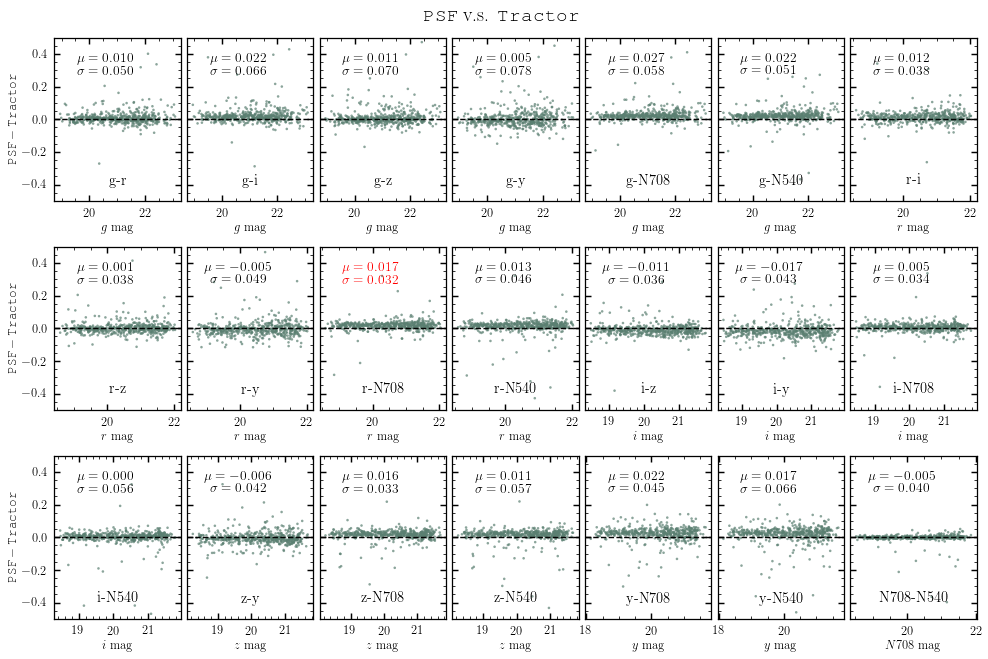

In [71]:
# mag-mag plot
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])

    color1 = gaap_cat['psf_mag'][:, filt1] - gaap_cat['psf_mag'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(gaap_cat['psf_mag'][:, filt1], color1 - color2,
                s=7, color='#5A7F71', alpha=0.7,
                label=aper, edgecolors='none')
    _mean = np.nanmean(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.5, 0.5)
    plt.text((xlim[0] + xlim[1]) / 2, -0.4, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.35, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.27, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{PSF} - \texttt{Tractor}$')
    
#     if i//7 == 2:
    plt.xlabel('$' + channels[filt1] + '\ \mathrm{mag}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.28)
plt.suptitle(r'$\texttt{PSF}$ v.s. $\texttt{Tractor}$', y=0.92, fontsize=20)

Text(0.5, 0.98, '$\\texttt{PSF}$ v.s. $\\texttt{Tractor}$')

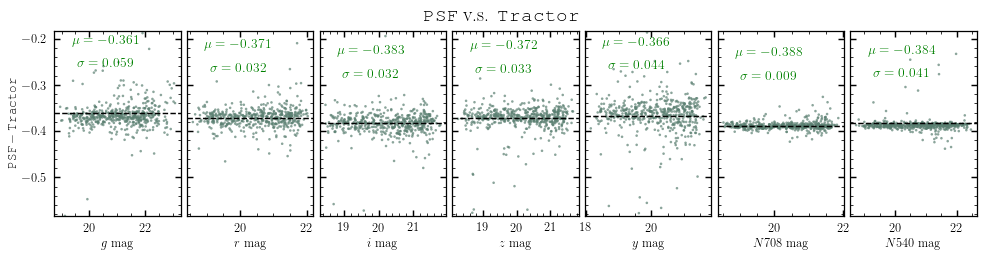

In [112]:
# all colors
fig, axes = plt.subplots(1, 7, figsize=(17, 3.5), sharey=True)

for i, filt in enumerate(channels):
    plt.sca(axes[i])
    diff = gaap_cat['psf_mag'][:, i] - meas_cat['mag'][:, i]
    plt.scatter(gaap_cat['psf_mag'][:, i], diff,
                s=7, color='#5A7F71', alpha=0.7,
                label=aper, edgecolors='none')
    _mean = np.nanmean(diff)
    _std = np.nanstd(diff)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(_mean, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.2 + _mean, 0.2 + _mean)
#     plt.text((xlim[0] + xlim[1]) / 2, -0.4 + _mean, 
#              channels[filt], 
#              ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.15 + _mean, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.10 + _mean, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i == 0:
        plt.ylabel(r'$\texttt{PSF} - \texttt{Tractor}$')
    
    plt.xlabel('$' + channels[i] + '\ \mathrm{mag}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.28)
plt.suptitle(r'$\texttt{PSF}$ v.s. $\texttt{Tractor}$', fontsize=20)

Text(0.5, 0.98, '$\\texttt{GAAP}$ v.s. $\\texttt{Tractor}$')

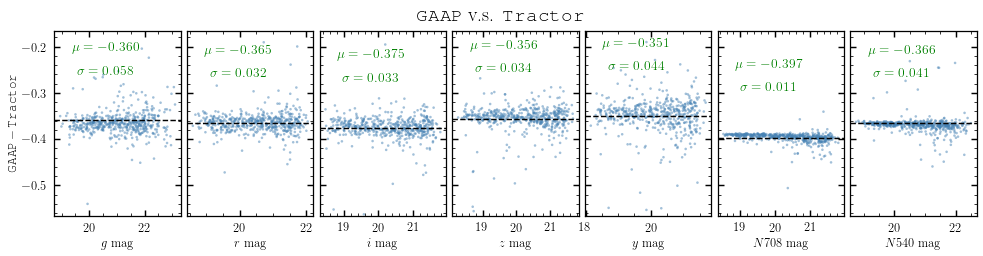

In [111]:
# all colors
fig, axes = plt.subplots(1, 7, figsize=(17, 3.5), sharey=True)

for i, filt in enumerate(channels):
    plt.sca(axes[i])
    diff = gaap_cat['gaap_mag_1p0'][:, i] - meas_cat['mag'][:, i]
    plt.scatter(gaap_cat['gaap_mag_1p0'][:, i], diff,
                s=7, color='steelblue', alpha=0.5,
                label=aper, edgecolors='none')
    _mean = np.nanmean(diff)
    _std = np.nanstd(diff)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(_mean, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.2 + _mean, 0.2 + _mean)
#     plt.text((xlim[0] + xlim[1]) / 2, -0.4 + _mean, 
#              channels[filt], 
#              ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.15 + _mean, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.10 + _mean, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{Tractor}$')
    
    plt.xlabel('$' + channels[i] + '\ \mathrm{mag}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.28)
plt.suptitle(r'$\texttt{GAAP}$ v.s. $\texttt{Tractor}$', fontsize=20)

Text(0.5, 0.98, '$\\texttt{GAAP}$ v.s. $\\texttt{PSF}$')

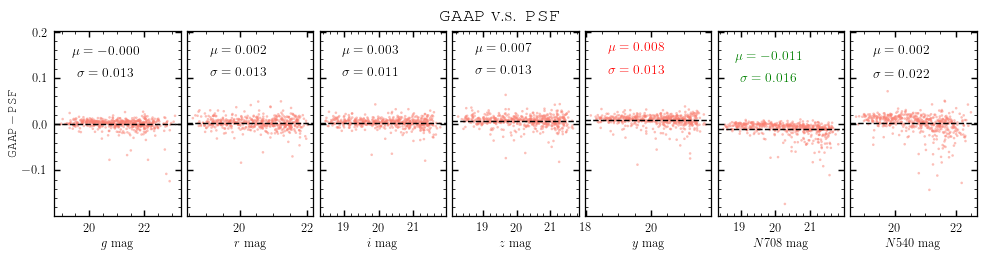

In [110]:
# all colors
fig, axes = plt.subplots(1, 7, figsize=(17, 3.5), sharey=True)

for i, filt in enumerate(channels):
    plt.sca(axes[i])
    diff = gaap_cat['gaap_mag_1p5'][:, i] - gaap_cat['psf_mag'][:, i]
    plt.scatter(gaap_cat['gaap_mag_1p5'][:, i], diff,
                s=7, color='salmon', alpha=0.5,
                label=aper, edgecolors='none')
    _mean = np.nanmean(diff)
    _std = np.nanstd(diff)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(_mean, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.2 + _mean, 0.2 + _mean)
#     plt.text((xlim[0] + xlim[1]) / 2, -0.4 + _mean, 
#              channels[filt], 
#              ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.15 + _mean, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.10 + _mean, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{PSF}$')
    
    plt.xlabel('$' + channels[i] + '\ \mathrm{mag}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.28)
plt.suptitle(r'$\texttt{GAAP}$ v.s. $\texttt{PSF}$', fontsize=20)

In [351]:
gi_gaap = (gaap_cat['gaap_mag_1p0'][:, 2] - gaap_cat['gaap_mag_1p0'][:, 5])
gi_tractor = (meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5])

In [336]:
np.where(((gi_gaap - gi_tractor) > 0.05) & (gi_gaap < -0.1))

(array([  5, 159, 226, 257, 266, 374, 379, 420, 440, 475, 497]),)